## Problem Statement

You are provided with a dataset of ~5k 512x512 images, your program should accept an
512x512 input image and return N images from the provided dataset similar to the input image.

In [ ]:
#Preparing Data Set
import zipfile
from google.colab import drive
import os
import cv2
from google.colab.patches import cv2_imshow
import random
from matplotlib import pyplot as plt
from tqdm import tqdm

#DataProcessing
import numpy as np
import pandas as pd

#Feature Extraction
import keras,os
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D , Flatten
from keras.optimizers import SGD
from keras.preprocessing.image import ImageDataGenerator
from sklearn.preprocessing import StandardScaler

#TSNE
from sklearn.manifold import TSNE
import seaborn as sn

## Preparing Data Set

In [ ]:
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
#!unzip "/content/drive/My Drive/MLTask/dataset.zip" -d "/content/drive/My Drive/MLTask/"

Number of images given - 4738
Number of Invalid files - 0
954.jpg


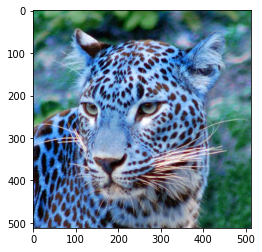

954.jpg - (512, 512, 3)
1509.jpg


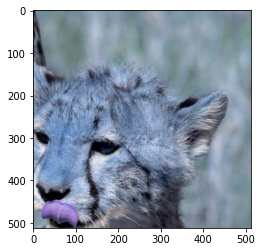

1509.jpg - (512, 512, 3)
303.jpg


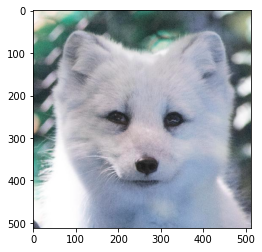

303.jpg - (512, 512, 3)
1247.jpg


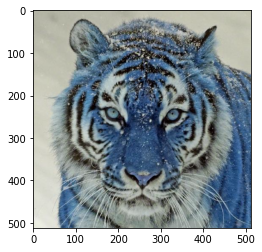

1247.jpg - (512, 512, 3)
3011.jpg


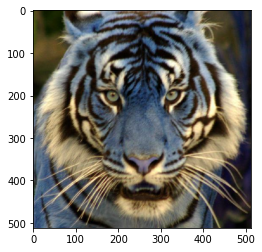

3011.jpg - (512, 512, 3)


In [ ]:
data_path = "/content/drive/My Drive/MLTask/dataset/"
n = os.listdir(data_path)

#Images where given in .jpg format

#Number of samples
print("Number of images given - "+ str(len(n)))

#Checking if there is any invalid extensions
invalid_files = 0
for i in n:
  no,ext = i.split(".")
  if ext != "jpg":
    print(i)
    invalid_files+=1
print("Number of Invalid files - "+str(invalid_files))

#Checking dimesnions of the images randomly
for i in range(5):
  sample_image = random.choice(n)
  print(sample_image)
  img = cv2.imread(data_path+sample_image)
  plt.imshow(img)
  plt.show()
  #cv2_imshow(img)
  print(str(sample_image)+" - "+str(img.shape))

# AutoEncoder

## Feature Extraction

In [ ]:
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Dense, Activation, Lambda, Flatten, concatenate, Reshape
from keras.models import Model
input_img = Input(shape=(128, 128, 3))

x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)


x = Conv2D(128, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='rmsprop', loss='mse')

autoencoder.summary()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 128, 128, 32)      896       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 64, 64, 64)        18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 32, 32, 128)       73856     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 16, 16, 128)      

In [ ]:
datagen = ImageDataGenerator(rescale=1. / 255)
train_generator = datagen.flow_from_directory(
    "/content/drive/My Drive/MLTask/", target_size=(128, 128), color_mode='rgb', classes=None,
    class_mode=None, batch_size=1, shuffle=False
)

Found 4738 images belonging to 1 classes.


In [ ]:
x_train_img = []
img_id=[]
for x in tqdm(range(4738)):
  val = train_generator[x]
  id = train_generator.filenames[x]
  img_id.append(id[8:-4])
  x_train_img.append(val)

100%|██████████| 4738/4738 [26:03<00:00,  3.03it/s]


In [ ]:

np.save(open('/content/drive/My Drive/MLTask/x_train_ea.npy', 'wb'), x_train_img)

#coresponding image id
np.save(open('/content/drive/My Drive/MLTask/image_id_ea.npy', 'wb'), img_id)

In [ ]:


x_train_img = np.load('/content/drive/My Drive/MLTask/x_train_ea.npy')
img_id = np.load('/content/drive/My Drive/MLTask/image_id_ea.npy')

In [ ]:
print(len(x_train_img))
print(len(img_id))

4738
4738


In [ ]:
X = np.array(x_train_img).reshape(-1, 128, 128, 3)

In [ ]:
X.shape

(4738, 128, 128, 3)

In [ ]:
autoencoder.fit(X,X,batch_size=1,epochs=100,steps_per_epoch=X.shape[0], validation_data=(X,X))

Epoch 1/100
4738/4738 [==============================] - 51s 11ms/step - loss: 0.0217 - val_loss: 0.0154
Epoch 2/100
4738/4738 [==============================] - 51s 11ms/step - loss: 0.0153 - val_loss: 0.0136
Epoch 3/100
4738/4738 [==============================] - 53s 11ms/step - loss: 0.0140 - val_loss: 0.0132
Epoch 4/100
4738/4738 [==============================] - 52s 11ms/step - loss: 0.0133 - val_loss: 0.0137
Epoch 5/100
4738/4738 [==============================] - 51s 11ms/step - loss: 0.0129 - val_loss: 0.0124
Epoch 6/100
4738/4738 [==============================] - 52s 11ms/step - loss: 0.0126 - val_loss: 0.0123
Epoch 7/100
4738/4738 [==============================] - 51s 11ms/step - loss: 0.0124 - val_loss: 0.0127
Epoch 8/100
4738/4738 [==============================] - 51s 11ms/step - loss: 0.0123 - val_loss: 0.0144
Epoch 9/100
4738/4738 [==============================] - 53s 11ms/step - loss: 0.0122 - val_loss: 0.0125
Epoch 10/100
4738/4738 [==============================]

In [ ]:
autoencoder.save('ae2.h5')

In [ ]:
'''
autoencoder.load_weights('/content/drive/My Drive/MLTask/ae2.h5')


In [ ]:
prediction = autoencoder.predict(X)

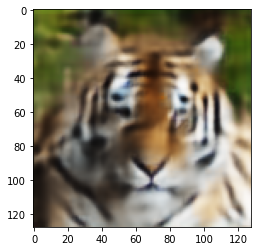

In [ ]:
plt.imshow(prediction[10])

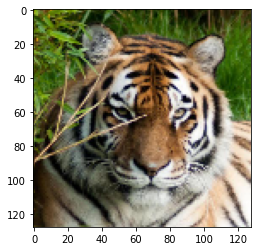

In [ ]:
plt.imshow(X[10])

In [ ]:
encoder = Model(input_img, encoded)
encoded_output = encoder.predict(X)

In [ ]:
#Extracted Features from the encoder
np.save(open('/content/drive/My Drive/MLTask/encoded_output.npy', 'wb'), encoded_output)

In [ ]:
#Flatening the extracted Features
a = encoded_output[0]
a = a.flatten()

In [ ]:
flatt = []
for i in range(4738):
  a = encoded_output[i]
  a = a.flatten()
  flatt.append(a)

In [ ]:
len(flatt)

4738

In [ ]:
X_comp = np.array(flatt)

In [ ]:
X_comp

array([[0.05642208, 0.33969668, 0.        , ..., 0.        , 0.        ,
        0.139863  ],
       [0.10283403, 0.12609616, 0.        , ..., 0.        , 0.        ,
        0.04170759],
       [0.05651936, 0.2149237 , 0.        , ..., 0.00312871, 0.        ,
        0.13967514],
       ...,
       [0.09079245, 0.18659891, 0.        , ..., 0.        , 0.        ,
        0.27077124],
       [0.02617195, 0.4005976 , 0.        , ..., 0.01961473, 0.        ,
        0.14531294],
       [0.10842428, 0.2106792 , 0.        , ..., 0.        , 0.        ,
        0.10955124]], dtype=float32)

In [ ]:
X_comp.shape

(4738, 8192)

In [ ]:
np.save(open('/content/drive/My Drive/MLTask/X_comp.npy', 'wb'), X_comp)

## Applying Extracted Features on TSNE

### TSNE Preplexity =30

In [ ]:
tsne_model = TSNE(n_components=2, random_state=0)
tsne_data = tsne_model.fit_transform(X_comp)

In [ ]:
tsne_data.shape

(4738, 2)

/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:243: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


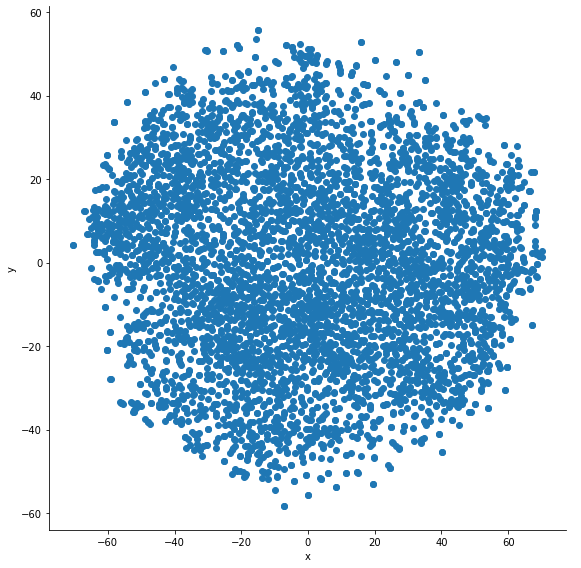

In [ ]:
tsne_df = pd.DataFrame(data=tsne_data, columns=("x", "y"))
sn.FacetGrid(tsne_df, size=8).map(plt.scatter,'x','y').add_legend()
plt.show()

### TSNE Preplexity =10

In [ ]:
tsne_model_ae01 = TSNE(n_components=2, random_state=0, perplexity=10)
tsne_data_ae01 = tsne_model_ae01.fit_transform(X_comp)

In [ ]:
tsne_data_ae01.shape

(4738, 2)

/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:243: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


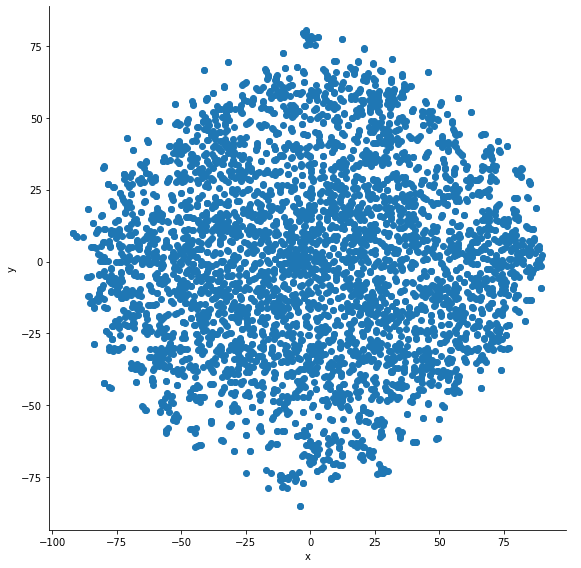

In [ ]:
tsne_df_ae01 = pd.DataFrame(data=tsne_data_ae01, columns=("x", "y"))
sn.FacetGrid(tsne_df_ae01, size=8).map(plt.scatter,'x','y').add_legend()
plt.show()

### PCA over TSNE

In [ ]:
pca_ae02 = PCA(n_components=2)
pca_data_ae02 = pca_ae02.fit_transform(tsne_data)

In [ ]:
pca_data_ae02

array([[  6.1057096,  -3.6945524],
       [-32.788452 , -19.52872  ],
       [ 12.653883 ,  33.390285 ],
       ...,
       [-50.95543  ,   3.876676 ],
       [-27.905003 ,  33.80078  ],
       [-60.80605  ,   7.071823 ]], dtype=float32)

/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:243: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


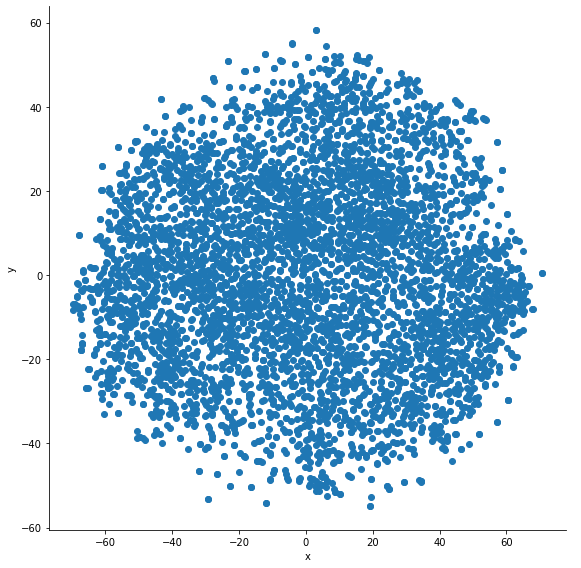

In [ ]:
pca_df_ae02 = pd.DataFrame(data=pca_data_ae02, columns=("x", "y"))
sn.FacetGrid(pca_df_ae02, size=8).map(plt.scatter,'x','y').add_legend()
plt.show()

## Applying K-Means on TSNE data


In [ ]:
### used data - tsne_df_ae01
from sklearn.cluster import KMeans

clusters=list(range(1,21))
kmn = []
sse = []
for c in clusters:
  kmeans = KMeans(n_clusters=c, random_state=0,n_init=20).fit(tsne_df_ae01)
  kmn.append(kmeans.labels_)
  sse.append(kmeans.inertia_)

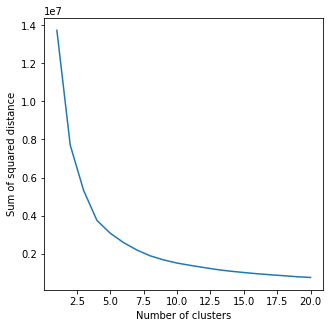

In [ ]:
plt.figure(figsize=(5, 5))
plt.plot(clusters, sse)
plt.xlabel('Number of clusters')
plt.ylabel('Sum of squared distance');

In [ ]:
huee = pd.DataFrame(data=kmn[4])

km_data = pd.DataFrame()
tsne_df = pd.DataFrame(data=tsne_df_ae01, columns=("x", "y"))

km_data = pd.concat([tsne_df,huee], axis=1, ignore_index=True)
km_data.columns=["x","y","label"]
print(km_data.shape)
km_data.head()

(4738, 3)


x          y  label
0  24.148758 -10.565076      1
1 -48.383770 -26.445084      3
2  10.728152  46.654701      0
3  -0.550965  -4.185192      1
4  51.714146  22.603729      4

/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:243: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


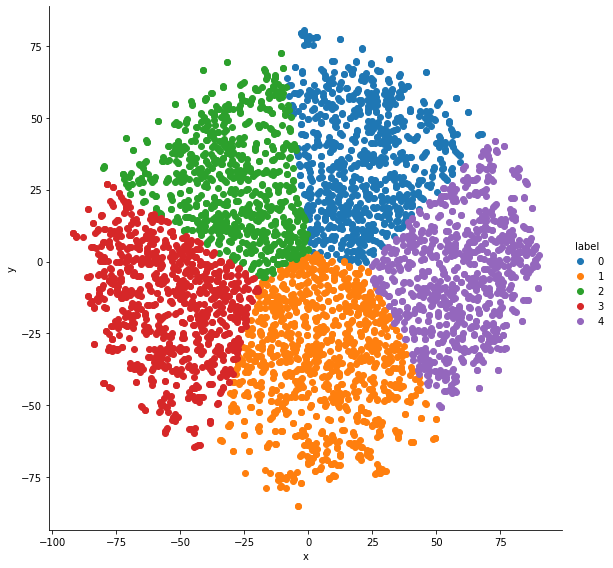

In [ ]:
sn.FacetGrid(km_data,hue='label', size=8).map(plt.scatter,'x','y').add_legend()
plt.show()

## Image Similarity

### Data Preparation for finding Similar Image

In [ ]:
img_id
img_id = pd.DataFrame(data=img_id)

In [ ]:
km = pd.DataFrame()
km = pd.concat([img_id,km_data], axis=1, ignore_index=True)
km.columns=("id","x","y","label")
km.head()

id          x          y  label
0     0  24.148758 -10.565076      1
1     1 -48.383770 -26.445084      3
2    10  10.728152  46.654701      0
3   100  -0.550965  -4.185192      1
4  1000  51.714146  22.603729      4

In [ ]:
sim = km.drop("label",axis=1)

In [ ]:
sim.head(5)

id          x          y
0     0  24.148758 -10.565076
1     1 -48.383770 -26.445084
2    10  10.728152  46.654701
3   100  -0.550965  -4.185192
4  1000  51.714146  22.603729

In [ ]:
new_dt =pd.DataFrame(X_comp)

In [ ]:
new_dt

0         1     2     3     ...  8188      8189  8190      8191
0     0.056422  0.339697   0.0   0.0  ...   0.0  0.000000   0.0  0.139863
1     0.102834  0.126096   0.0   0.0  ...   0.0  0.000000   0.0  0.041708
2     0.056519  0.214924   0.0   0.0  ...   0.0  0.003129   0.0  0.139675
3     0.011507  0.183190   0.0   0.0  ...   0.0  0.000000   0.0  0.038615
4     0.078122  0.394140   0.0   0.0  ...   0.0  0.000000   0.0  0.122489
...        ...       ...   ...   ...  ...   ...       ...   ...       ...
4733  0.345317  0.172720   0.0   0.0  ...   0.0  0.000000   0.0  0.061572
4734  0.191320  0.109166   0.0   0.0  ...   0.0  0.000000   0.0  0.158743
4735  0.090792  0.186599   0.0   0.0  ...   0.0  0.000000   0.0  0.270771
4736  0.026172  0.400598   0.0   0.0  ...   0.0  0.019615   0.0  0.145313
4737  0.108424  0.210679   0.0   0.0  ...   0.0  0.000000   0.0  0.109551

[4738 rows x 8192 columns]

In [ ]:
img_id.head()

0
0     0
1     1
2    10
3   100
4  1000

### Image similarity using TSNE data(reduced dimensions)

In [ ]:
sim.drop('id',axis=1)

x          y
0     24.148758 -10.565076
1    -48.383770 -26.445084
2     10.728152  46.654701
3     -0.550965  -4.185192
4     51.714146  22.603729
...         ...        ...
4733 -27.252396 -16.717489
4734 -32.232277  50.497021
4735 -59.804161   2.342370
4736 -23.490307  28.248363
4737 -81.084084   5.324223

[4738 rows x 2 columns]

In [ ]:
pairwise_dist_tsne = pairwise_distances(sim)

In [ ]:
pairwise_dist_tsne.shape

(4738, 4738)

In [ ]:
## pairwise_dist_for_tsne - reduced dim
np.save(open('/content/drive/My Drive/MLTask/pairwise_dist_for_tsne.npy', 'wb'), pairwise_dist_tsne)

[1112  557  113 2223 1001 2335 1668 1779 2446 2779]


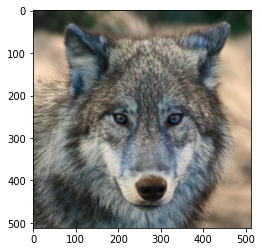

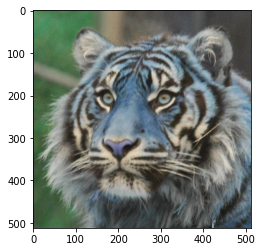

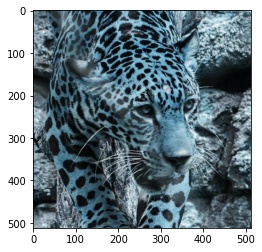

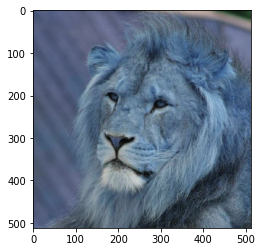

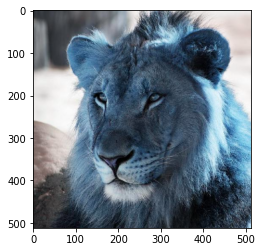

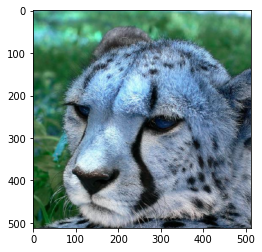

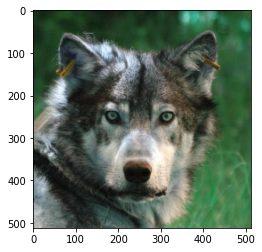

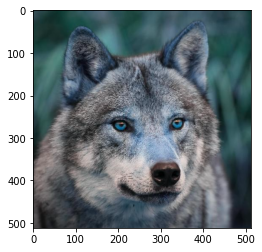

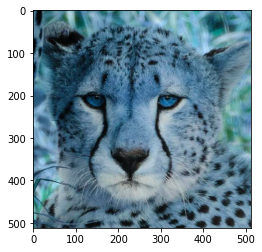

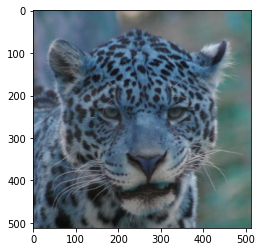

In [ ]:
data_path = "/content/drive/My Drive/MLTask/dataset/"
def get_similar_tsne(n,num_results):
  n = str(n)
  image_id = ids.index(n)

  indices = np.argsort(pairwise_dist_tsne[image_id].flatten())[0:num_results]
  print(indices)
  for i in range(len(indices)):
        img = asins[indices[i]]
        #print(img)
        sample_image = str(img)+".jpg"
        img = cv2.imread(data_path+sample_image)
        plt.imshow(img)
        plt.show()
get_similar_tsne(2,10)
        

[540 543 553 509 515 573 516 555 506 538]


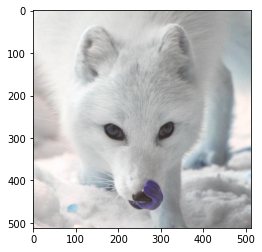

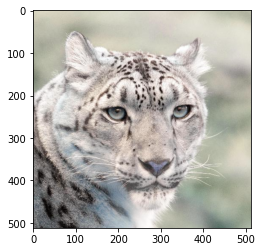

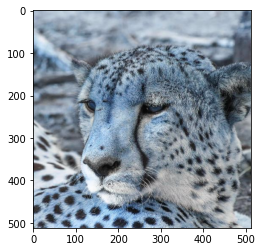

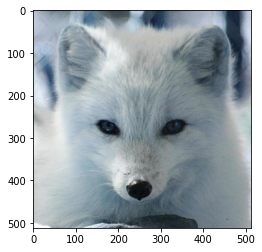

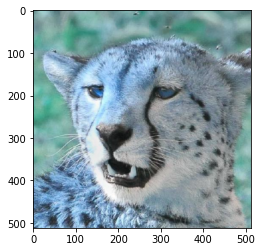

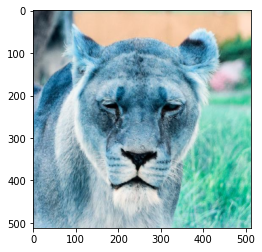

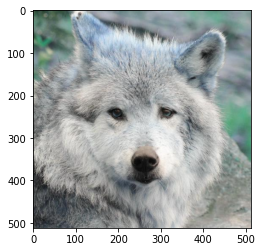

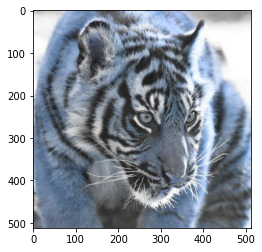

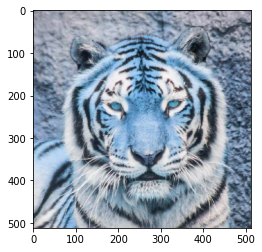

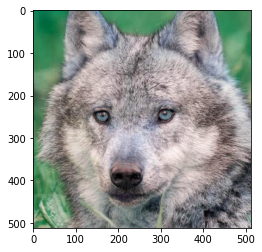

In [ ]:
get_similar_tsne(1484,10)

### Image Similarity using original encoded features

In [ ]:
pairwise_dist = pairwise_distances(new_dt)

In [ ]:
## pairwise_dist_for_org_features - original extracted features
np.save(open('/content/drive/My Drive/MLTask/pairwise_dist_for_org_features.npy', 'wb'), pairwise_dist)

In [ ]:


pairwise_dist = np.load('/content/drive/My Drive/MLTask/pairwise_dist_for_org_features.npy')

In [ ]:
ids = list(img_id[0])

In [ ]:
from sklearn import pairwise_distances
data_path = "/content/drive/My Drive/MLTask/dataset/"
def get_similar(n,num_results):
  n = str(n)
  image_id = ids.index(n)
  pairwise_dist = pairwise_distances(new_dt)

  indices = np.argsort(pairwise_dist[image_id].flatten())[0:num_results]
  print(indices)
  for i in range(len(indices)):
        img = asins[indices[i]]
        #print(img)
        sample_image = str(img)+".jpg"
        img = cv2.imread(data_path+sample_image)
        plt.imshow(img)
        plt.show()
get_similar(555,10)
        

[ 499 3418 4418 3222 2578  652  388 1754 2484 3285]


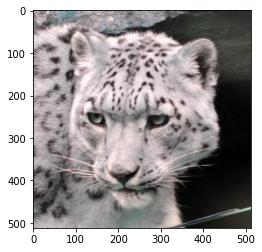

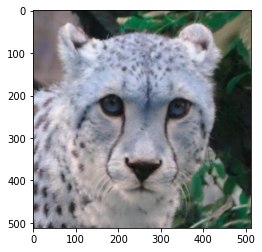

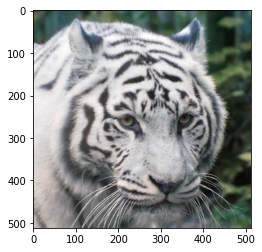

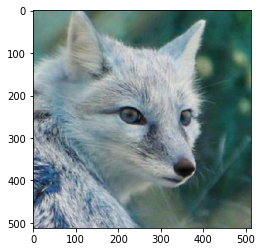

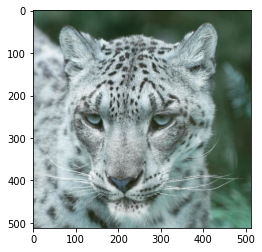

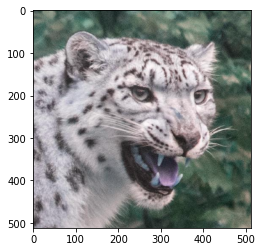

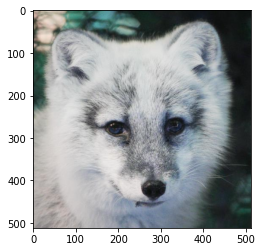

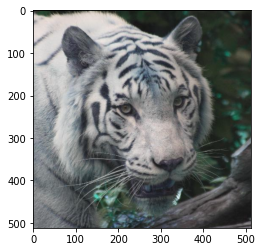

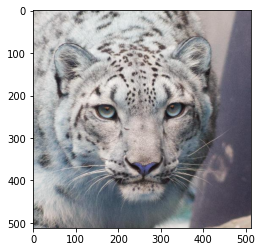

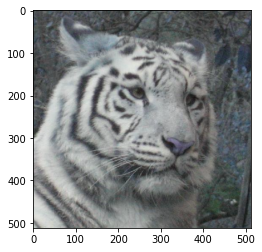

In [ ]:
get_similar(1447,10)

[ 540 1252 1770 1168 2451 3455 4452 1761 2704 3574]


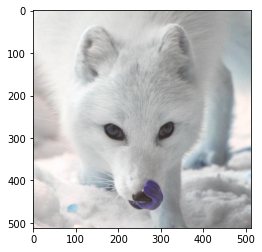

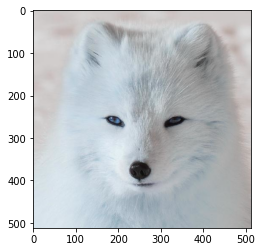

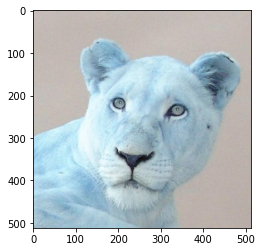

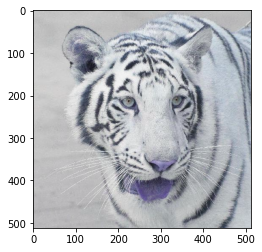

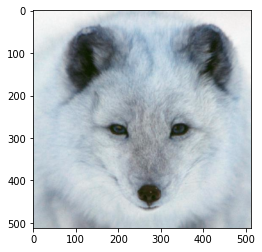

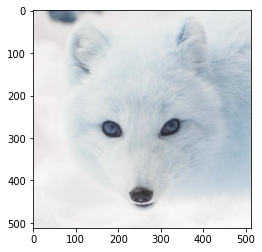

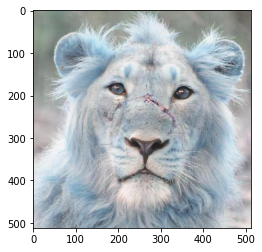

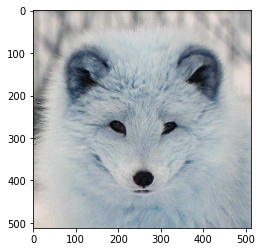

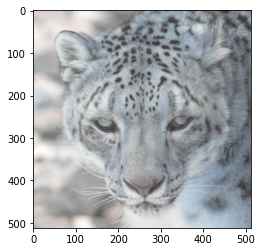

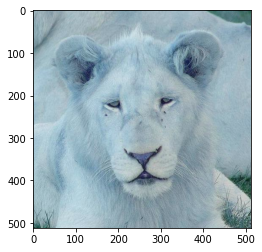

In [ ]:
get_similar(1484,10)

[ 579 4443 1766 1995 4244   62  385 2211 1183 3758]


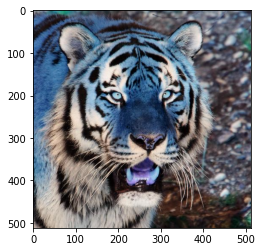

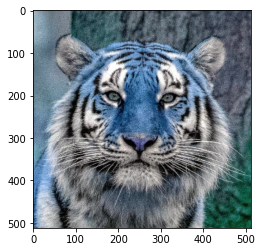

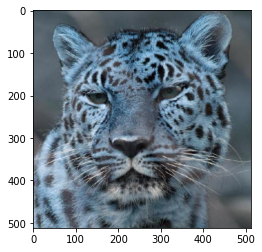

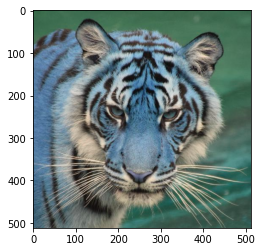

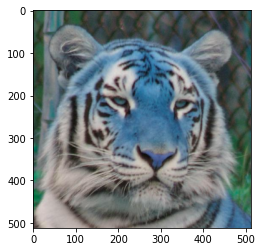

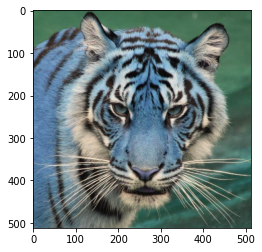

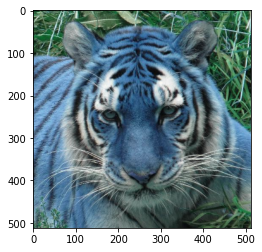

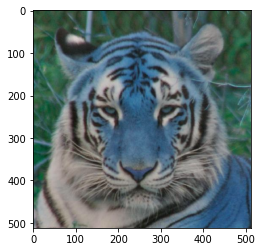

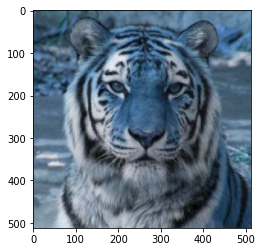

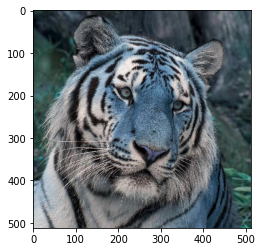

In [ ]:
get_similar(1519,10)

## Conclusion

The Perfomance was better when we used the original extracted features from the autoencoder model